In [53]:
!pip install catboost
!pip install lightgbm
!pip install xgboost
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 5.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [167]:
import os
from pprint import pprint

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import seaborn as sns
import warnings; warnings.filterwarnings(action='ignore') # 경고 메시지 무시
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [203]:
ROOT_DIR = "data"
RANDOM_STATE = 42

# Load data
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
train_data

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,CURE END POSITION X Judge Value_Dam,...,Production Qty Collect Result_Fill2,Production Qty Unit Time_Fill2,Production Qty Judge Value_Fill2,Receip No Collect Result_Fill2,Receip No Unit Time_Fill2,Receip No Judge Value_Fill2,WorkMode Collect Result_Fill2,WorkMode Unit Time_Fill2,WorkMode Judge Value_Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,1,OK,240.0,NaN,NaN,...,7,NaN,NaN,127,NaN,NaN,1,NaN,NaN,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,1,OK,240.0,NaN,NaN,...,185,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1,OK,1000.0,NaN,NaN,...,10,NaN,NaN,73,NaN,NaN,1,NaN,NaN,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1,OK,1000.0,NaN,NaN,...,268,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,1,OK,240.0,NaN,NaN,...,121,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3J1XF434-2,1,OK,240.0,NaN,NaN,...,318,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XC796-1,1,OK,1000.0,NaN,NaN,...,14,NaN,NaN,197,NaN,NaN,1,NaN,NaN,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4C1XD438-1,1,OK,240.0,NaN,NaN,...,1,NaN,NaN,27,NaN,NaN,1,NaN,NaN,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3I1XA258-1,1,OK,1000.0,NaN,NaN,...,117,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal


In [204]:
# 모든 값이 동일할 때 컬럼을 제거
train_data = train_data.loc[:, (train_data != train_data.iloc[0]).any()]
test_data = test_data.loc[:, (test_data != test_data.iloc[0]).any()]

In [205]:
# 모든 값이 NAN인 열 제거  (151개)
# train_data = train_data.dropna(axis=1, how='all')
# test_data = test_data.dropna(axis=1, how='all')

# 하나라도 값이 NaN인 열 제거 -> 모든 값 NaN + OK 되어 있는 부분 처리 가능 (총 143개의 열만 남음)
train_data.dropna(axis=1, inplace=True)
test_data.dropna(axis=1, inplace=True)

train_data

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334505,4F1XA938-1,240.0,2.5,-90,100,1030,-90,16,...,50.0,91.8,270,50,114.612,19.9,7,127,1,Normal
1,Dam dispenser #1,AJX75334505,3KPM0016-2,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.600,7.0,185,1,0,Normal
2,Dam dispenser #2,AJX75334501,4E1X9167-1,1000.0,12.5,90,85,280,90,16,...,50.0,91.8,270,50,114.612,19.8,10,73,1,Normal
3,Dam dispenser #2,AJX75334501,3K1X0057-1,1000.0,12.5,90,70,280,90,10,...,91.8,270.0,50,85,19.900,12.0,268,1,0,Normal
4,Dam dispenser #1,AJX75334501,3HPM0007-1,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.700,8.0,121,1,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,AJX75334501,3J1XF434-2,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.200,1.0,318,1,0,Normal
40502,Dam dispenser #2,AJX75334501,4E1XC796-1,1000.0,12.5,90,100,280,90,16,...,50.0,91.8,270,50,114.612,20.5,14,197,1,Normal
40503,Dam dispenser #1,AJX75334501,4C1XD438-1,240.0,2.5,-90,100,1030,-90,16,...,50.0,91.8,270,50,85.000,19.7,1,27,1,Normal
40504,Dam dispenser #2,AJX75334501,3I1XA258-1,1000.0,12.5,90,70,280,90,10,...,91.8,270.0,50,85,20.100,13.0,117,1,0,Normal


In [166]:
for col in train_data.columns:
    print(col,":",train_data[col].nunique())

Equipment_Dam : 2
Model.Suffix_Dam : 7
Workorder_Dam : 663
CURE END POSITION X Collect Result_Dam : 2
CURE END POSITION Z Collect Result_Dam : 2
CURE END POSITION Θ Collect Result_Dam : 2
CURE SPEED Collect Result_Dam : 5
CURE START POSITION X Collect Result_Dam : 2
CURE START POSITION Θ Collect Result_Dam : 2
DISCHARGED SPEED OF RESIN Collect Result_Dam : 3
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam : 19
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam : 29
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam : 20
Dispense Volume(Stage1) Collect Result_Dam : 23
Dispense Volume(Stage2) Collect Result_Dam : 33
Dispense Volume(Stage3) Collect Result_Dam : 22
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam : 41
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam : 40
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam : 36
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam : 16
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam : 15
HEAD NORMAL CO

### Remove Outlier

In [116]:
# ## normal data와 abnormal 데이터 나누기 ##
# normal_data = train_data[train_data['target'] == "Normal"]
# abnormal_data = train_data[train_data['target'] == "AbNormal"]


# # ## 결측치 그래프 뽑아보기
# # def boxplot_vis(data, target_name):
# #     plt.figure(figsize=(30, 30))
# #     for col_idx in range(len(data.columns)):
# #         # 6행 2열 서브플롯에 각 feature 박스플롯 시각화
# #         plt.subplot(50, 3, col_idx+1)
# #         # flierprops: 빨간색 다이아몬드 모양으로 아웃라이어 시각화
# #         plt.boxplot(data[data.columns[col_idx]], flierprops = dict(markerfacecolor = 'r', marker = 'D'))
# #         # 그래프 타이틀: feature name
# #         plt.title("Feature" + "(" + target_name + "):" + data.columns[col_idx], fontsize = 20)
# #     plt.show()
 
# ## 이상치 제거
# def remove_outlier(data, cols):
#     for col in cols:
#         if data[col].dtype != 'object':
#             q1 = np.percentile(data[col], 25) # 제 1사분위수
#             q3 = np.percentile(data[col], 75) # 제 3사분위수
#             iqr = q3 - q1 # IQR(Interquartile range) 계산
#             minimum = q1 - (iqr * 1.5) # IQR 최솟값
#             maximum = q3 + (iqr * 1.5) # IQR 최댓값
#             # IQR 범위 내에 있는 데이터만 산출(IQR 범위 밖의 데이터는 이상치)
#             df_removed_outlier = data[(minimum < data[col]) & (data[col] < maximum)]
#     return df_removed_outlier 
    
# normal_remove_outlier = remove_outlier(normal_data, normal_data.columns)
# # abnormal_remove_outlier = remove_outlier(abnormal_data, abnormal_data.columns)

# # train_data = pd.concat([normal_remove_outlier, abnormal_remove_outlier])
# train_data = pd.concat([normal_remove_outlier, abnormal_data])
# train_data = train_data.sample(frac=1).reset_index(drop=True)

# train_data

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334501,3M1XB524-1,240.0,2.5,-90,70,1030,-90,16,...,50.0,91.8,270,50,85.0,20.4,3,98,1,Normal
1,Dam dispenser #1,AJX75334501,3M1XG841-1,240.0,2.5,-90,70,1030,-90,16,...,50.0,91.8,270,50,85.0,19.5,3,172,1,Normal
2,Dam dispenser #1,AJX75334501,3G1XC619-2,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,18.7,1.0,16,1,0,Normal
3,Dam dispenser #1,AJX75334501,3H1X3338-1,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.8,3.0,265,1,0,Normal
4,Dam dispenser #1,AJX75334501,3I1X9722-1,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.4,4.0,73,1,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39406,Dam dispenser #2,AJX75334501,3L1XA127-1,1000.0,12.5,90,70,280,90,16,...,50.0,91.8,270,50,85.0,20.0,10,271,1,Normal
39407,Dam dispenser #1,AJX75334501,3G1X4501-1,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.0,6.0,62,1,0,Normal
39408,Dam dispenser #1,AJX75334501,3J1X8954-1,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.5,7.0,117,1,0,Normal
39409,Dam dispenser #2,AJX75334501,3L1X8506-1,1000.0,12.5,90,70,280,90,10,...,50.0,91.8,270,50,85.0,19.5,13,322,1,Normal


### Label Encoding

In [216]:
# 데이터프레임에서 문자열 데이터가 있는 열에 대해 Label Encoding 적용
label_encoders = {}

for column in train_data.columns:
#     if train_data[column].dtype == 'object':  # 문자열 데이터를 확인
    le = LabelEncoder()
    train_data[column] = le.fit_transform(train_data[column].astype(str))  # Label Encoding 적용
    label_encoders[column] = le  # 나중에 디코딩할 수 있도록 레이블 인코더 저장
        
for column in test_data.columns:
#     if test_data[column].dtype == 'object':  # 문자열 데이터를 확인
    le = LabelEncoder()
    test_data[column] = le.fit_transform(test_data[column].astype(str))  # Label Encoding 적용
    label_encoders[column] = le  # 나중에 디코딩할 수 있도록 레이블 인코더 저장

In [222]:
train_data # normal:1, abnormal:0

[  2   7 663   2   2   2   5   2   2   3  19  29  20  23  33  22  41  40
  36  16  15  16  24  24  23   2   2   2   2   4   4   2   4   2   3   3
 266 374 486 607   8   7   7   7   8   8   8   8   8   9   9   9   9   9
  10   9  10   7   7   7   8   7   8   7   6   7   8   8   7 663  27   9
  67  10  67  11  26  24   2   2   7 663   4  16  24  16  16  27  16  18
  20  12  19  15  20  19  18  18   2   2   2   2   2   2   2   3 194 301
 486 607   7   2   7 663   2   3   8   4   2   4   5   4   5   3   3   4
   2   2   3   2   2   2   2   2   2   2   2  42  89 486 607   6   2]


### DATA Normalization (할 필요 없음)

In [96]:
# ## train data Normalization ## target 은 0,1 유지 하도록 함.
# train_scaled = train_data.drop("target", axis = 1)
# target = train_data['target']

# scaler = StandardScaler()
# train_data_scaled = scaler.fit_transform(train_scaled)
# train_data_scaled_df = pd.DataFrame(train_data_scaled, columns=train_scaled.columns)
# train_data = pd.concat([train_data_scaled_df, target], axis=1)

# ## test data Normalization ##
# test_data_scaled = scaler.fit_transform(test_data)
# test_data = pd.DataFrame(test_data_scaled, columns= test_data.columns)
# train_data

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,-0.777592,2.910144,1.430329,-0.777592,-0.777592,-0.777592,1.155915,0.777592,-0.777592,1.070987,...,-0.848771,-0.848771,0.848771,-0.848771,1.469982,1.015834,-0.664619,-0.285224,0.848771,1
1,-0.777592,-0.345852,-0.023293,-0.777592,-0.777592,-0.777592,-0.391209,0.777592,-0.777592,-0.933771,...,-0.848771,-0.848771,0.848771,-0.848771,0.657897,0.755135,-0.702294,-0.675012,0.848771,1
2,-0.777592,-0.345852,-0.125501,-0.777592,-0.777592,-0.777592,-0.391209,0.777592,-0.777592,-0.933771,...,-0.848771,-0.848771,0.848771,-0.848771,0.657897,0.782577,-0.655200,-0.269938,0.848771,1
3,1.286022,2.910144,1.912978,1.286022,1.286022,1.286022,2.703040,-1.286022,1.286022,1.070987,...,-0.848771,-0.848771,0.848771,-0.848771,1.469982,0.823740,-0.561012,0.287994,0.848771,1
4,1.286022,-0.345852,1.367869,1.286022,1.286022,1.286022,1.155915,-1.286022,1.286022,1.070987,...,-0.848771,-0.848771,0.848771,-0.848771,1.469982,0.947229,-0.589269,0.249780,0.848771,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39272,1.286022,-0.345852,1.004464,1.286022,1.286022,1.286022,-0.391209,-1.286022,1.286022,1.070987,...,-0.848771,-0.848771,0.848771,-0.848771,0.657897,0.727693,-0.598688,0.792426,0.848771,1
39273,1.286022,-0.345852,0.521815,1.286022,1.286022,1.286022,-0.391209,-1.286022,1.286022,1.070987,...,-0.848771,-0.848771,0.848771,-0.848771,0.657897,0.741414,-0.608106,2.649652,0.848771,1
39274,-0.777592,-0.345852,1.186166,-0.777592,-0.777592,-0.777592,3.218748,0.777592,-0.777592,1.070987,...,-0.848771,-0.848771,0.848771,-0.848771,0.657897,0.755135,-0.664619,-0.231723,0.848771,1
39275,-0.777592,-0.345852,-1.567767,-0.777592,-0.777592,-0.777592,-0.391209,0.777592,-0.777592,-0.933771,...,1.178174,1.178174,-1.178174,1.178174,-1.163069,-1.261855,2.801489,-0.812584,-1.178174,1


In [211]:
# normal_ratio = 3.0  # 1.0 means 1:1 ratio

# df_normal = train_data[train_data["target"] == 1]
# df_abnormal = train_data[train_data["target"] == 0]

# num_normal = len(df_normal)
# num_abnormal = len(df_abnormal)
# print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

# df_normal = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=RANDOM_STATE)
# df_concat = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)
# df_concat.value_counts("target")

# df_concat

  Total: Normal: 38156, AbNormal: 2350


,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,1,3,659,0,0,1,0,1,1,2,...,0,1,0,0,0,34,46,191,1,1
1,0,0,301,1,1,0,2,0,0,0,...,0,1,0,0,41,22,453,109,1,1
2,0,0,512,1,1,0,2,0,0,2,...,0,1,0,0,41,28,1,596,1,1
3,0,0,46,1,1,0,2,0,0,0,...,1,0,1,1,12,85,285,1,0,1
4,1,0,299,0,0,1,2,1,1,0,...,0,1,0,0,41,24,24,208,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9395,0,0,517,1,1,0,2,0,0,2,...,0,1,0,0,41,23,1,596,1,0
9396,0,0,77,1,1,0,2,0,0,0,...,1,0,1,1,14,87,443,1,0,0
9397,1,1,257,0,0,1,2,1,1,0,...,1,0,1,1,23,2,73,1,0,0
9398,0,0,50,1,1,0,2,0,0,0,...,1,0,1,1,17,0,171,1,0,0


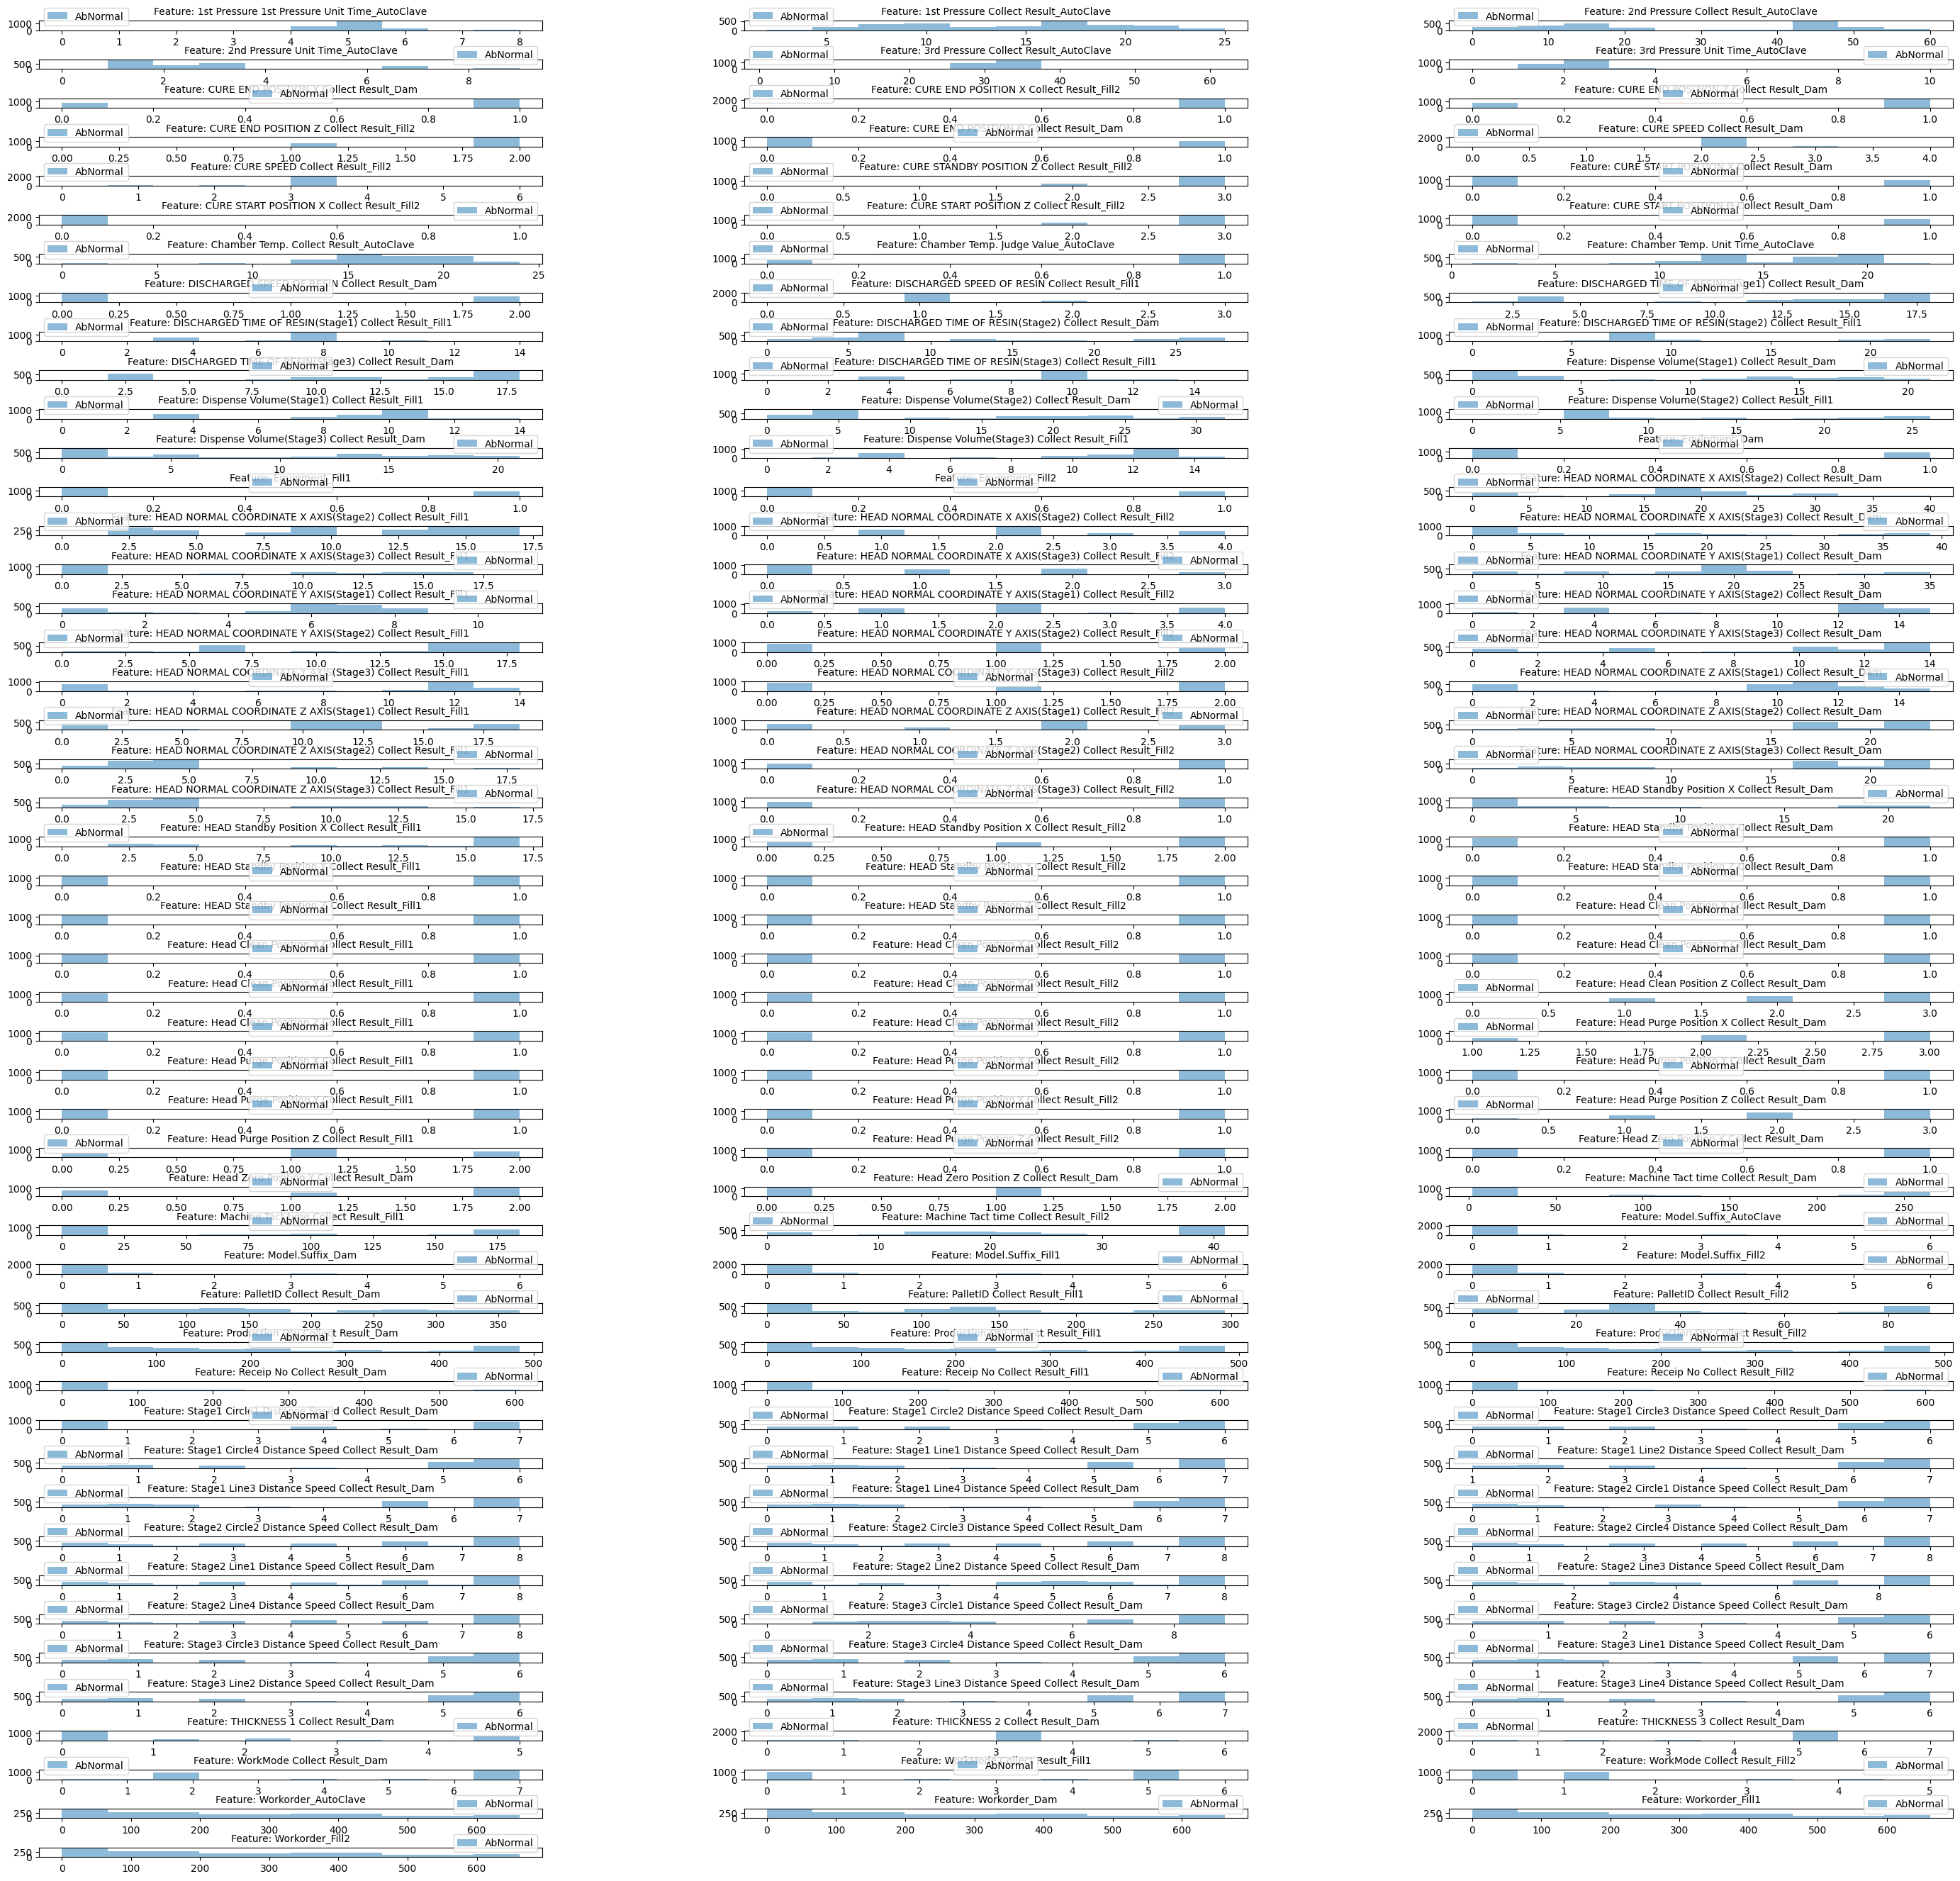

In [200]:
# 설명변수 선정 (df_concat)
x = df_concat[df_concat.columns.difference(['target'])]
# 설명변수명 리스트
feature_name = x.columns
plt.figure(figsize=(30, 30))
num = 0
for col_idx in range(len(feature_name)):
    # 
    plt.subplot(50, 3, col_idx+1)
    # abnormal에 해당하는 데이터 histogram 시각화
    plt.hist(df_concat[df_concat["target"] == 0][feature_name[col_idx]], label = "AbNormal", alpha = 0.5)
    # normal에 해당하는 데이터 histogram 시각화
    plt.hist(df_concat[df_concat["target"] == 1][feature_name[col_idx]], label = "Normal", alpha = 0.5)
    plt.legend()
    # 그래프 타이틀: feature name
    plt.title("Feature: "+ feature_name[col_idx], fontsize = 10)

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.4, hspace=3.0)
plt.savefig('./relationship.png')
plt.show()

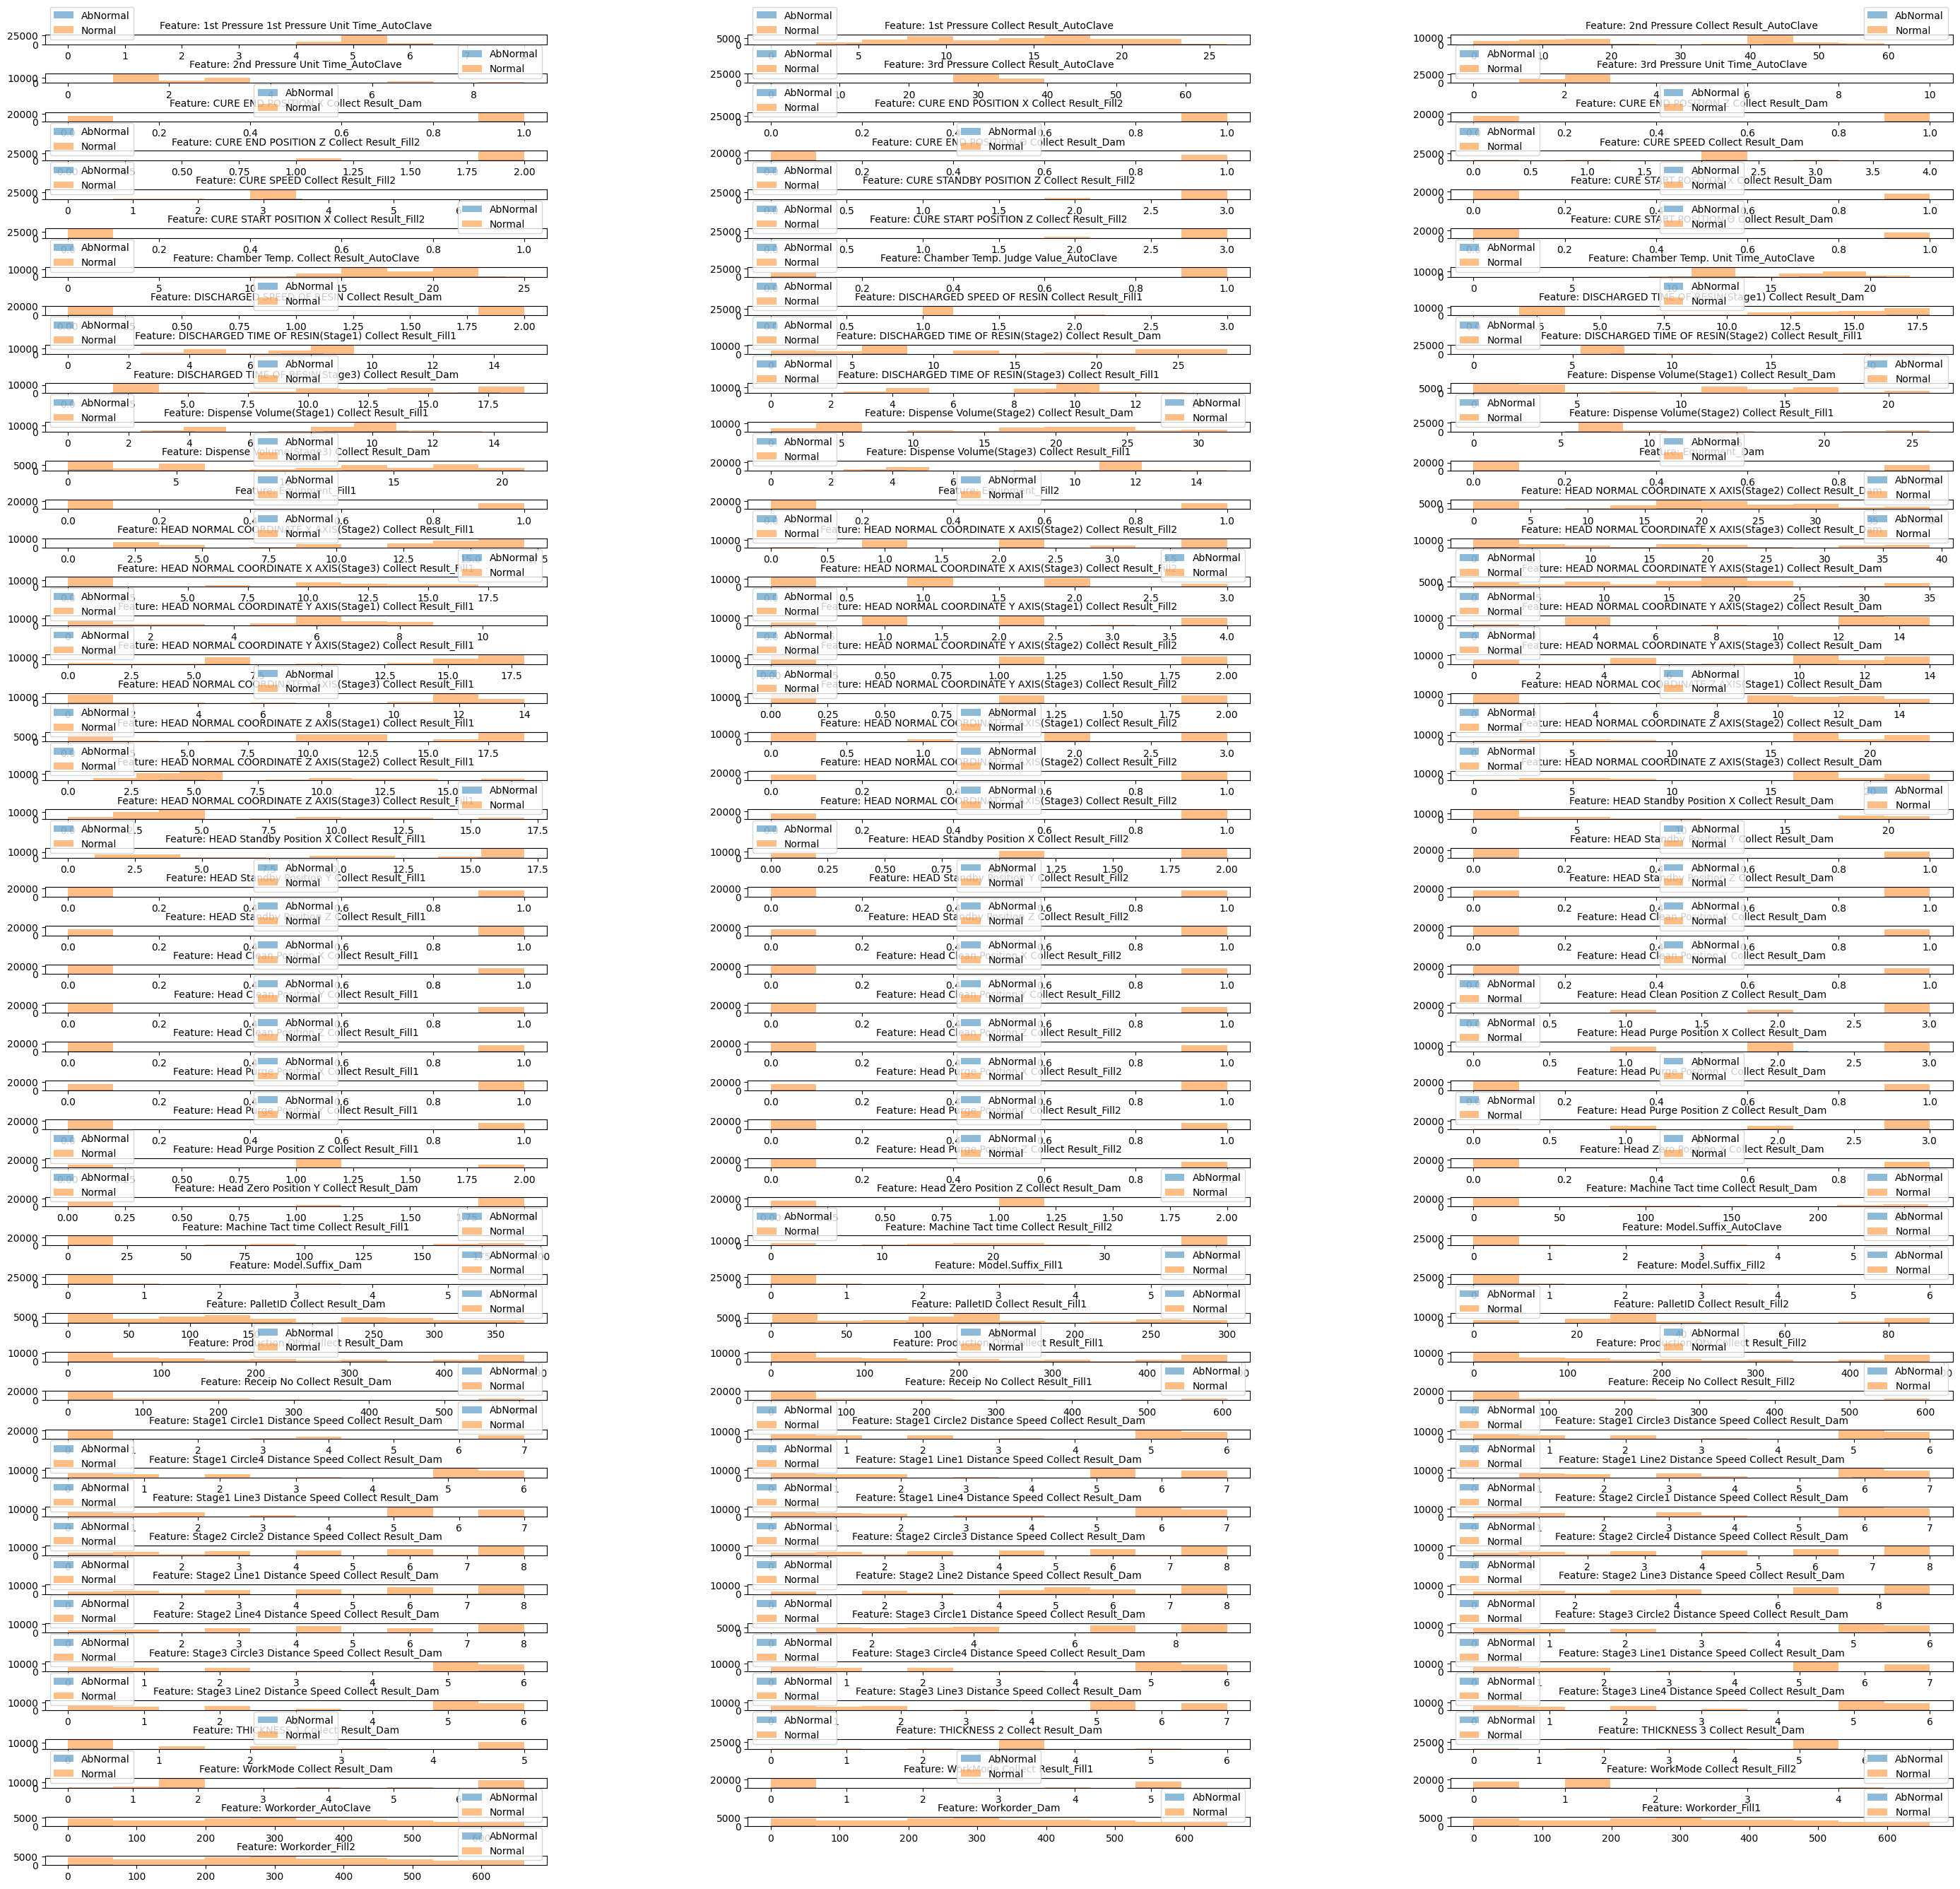

In [197]:
# 설명변수 선정
x = train_data[train_data.columns.difference(['target'])]
# 설명변수명 리스트
feature_name = x.columns
plt.figure(figsize=(30, 30))
num = 0
for col_idx in range(len(feature_name)):
    # 
    plt.subplot(50, 3, col_idx+1)
    # abnormal에 해당하는 데이터 histogram 시각화
    plt.hist(train_data[train_data["target"] == 0][feature_name[col_idx]], label = "AbNormal", alpha = 0.5)
    # normal에 해당하는 데이터 histogram 시각화
    plt.hist(train_data[train_data["target"] == 1][feature_name[col_idx]], label = "Normal", alpha = 0.5)
    plt.legend()
    # 그래프 타이틀: feature name
    plt.title("Feature: "+ feature_name[col_idx], fontsize = 10)

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.4, hspace=3.0)
plt.savefig('./relationship.png')
plt.show()

In [296]:
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import classification_report


features = [] # -- features 설정

# for col in train_data.columns:
#     try:
#         train_data[col] = df_train[col].astype(int)
#     except:
#         continue
 
features = [col for col in train_data.columns if train_data[col].nunique() < 8]
features.remove('target')

sum = 0
for i in features:
    sum +=1

print(sum)



# X = train_data.drop("target", axis = 1)
X = train_data[features]
y = train_data["target"]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

enn = EditedNearestNeighbours(n_neighbors=4)
X_data, y_data = enn.fit_resample(X, y)

69


In [297]:
normal = []
abnormal = []
for i in y_data:
    if i ==1:
        normal.append(i)
    else:
        abnormal.append(i)

print(len(normal) + len(abnormal))        
print(len(normal))
print(len(abnormal))

36760
34410
2350


In [298]:
from imblearn.over_sampling import RandomOverSampler

# 랜덤 오버샘플링 적용
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_data, y_data)

In [299]:
normal = []
abnormal = []
for i in y_resampled:
    if i ==1:
        normal.append(i)
    else:
        abnormal.append(i)

print(len(normal) + len(abnormal))        
print(len(normal))
print(len(abnormal))

68820
34410
34410


In [300]:
y_resampled

0        0
1        0
2        0
3        0
4        0
        ..
68815    0
68816    0
68817    0
68818    0
68819    0
Name: target, Length: 68820, dtype: int64

In [301]:
catboost_model = CatBoostClassifier(random_seed=42, verbose=False)
xgboost_model = XGBClassifier(random_seed = 42)
randomforest_model = RandomForestClassifier(n_estimators = 100, random_state=42) # class_weight 적용 가능 

In [302]:
randomforest_model.fit(X_resampled, y_resampled)
importances = randomforest_model.feature_importances_

for i in importances:
    print(i)

0.007419113856737583
0.028745210687958468
0.009571577078255962
0.008248510625616816
0.009329005389281187
0.0717221028485367
0.008029795657363472
0.006574104452930481
0.004113665098230609
0.001995572520041902
0.0002018326835168524
0.0013630687279685997
0.0014405938794656058
0.010059610430437231
0.011463660966283823
0.00016969320789128256
0.01123365683458457
0.00010543069053964064
0.01895502961224731
0.01892054099069863
0.02335608246330469
0.018741008024181306
0.020330190470078145
0.02866148753402545
0.01449310937780587
0.021546691094932225
0.023514080124098412
0.018988742321799215
0.0072589002485090315
0.11597258451514905
0.026047275394381786
0.19363544797504798
0.004495065017997549
0.029627930640272037
0.01076942437798754
0.0003336121065206118
0.00019392413055048876
0.00032222912188049744
0.0026246258326958426
7.524932492845092e-05
0.00040680999651210076
0.0005976774912637107
0.02023534848695141
0.031053923116048862
0.005015753582804353
0.02845687460561816
0.001734388302575216
0.011484

In [307]:

sfm = SelectFromModel(randomforest_model,threshold='1.25*median', prefit=True)
selected_features = X_resampled.columns[sfm.get_support()]
selected_train_x = X_resampled[selected_features]
randomforest_model.fit(selected_train_x, y_resampled)

# ser = pd.Series(randomforest_model.feature_importances_, index=selected_features)
# top20 = ser.sort_values(ascending=False)[:20]
# print(top20)
# plt.figure(figsize=(8,6))
# plt.title('Feature Importances Top 20')
# sns.barplot(x=top20, y=top20.index)
# plt.show()

S_kfold = StratifiedKFold(n_splits=5)

cv_accuracy = []
n_iter = 0
for train_index, test_index in S_kfold.split(selected_train_x, y):  
    x_train_k_fold, x_test_k_fold = selected_train_x.iloc[train_index], selected_train_x.iloc[test_index]
    y_train_k_fold, y_test_k_fold = y.iloc[train_index], y.iloc[test_index]
    
    randomforest_model.fit(x_train_k_fold, y_train_k_fold)
    pred = randomforest_model.predict(x_test_k_fold)
    n_iter += 1
    
#     accuracy = np.round(accuracy_score(y_test_k_fold, pred), 4)
#     precision = precision_score(y_test_k_fold, pred,average= "macro")
#     recall = recall_score(y_test_k_fold, pred,average= "macro")
#     f1 = f1_score(y_test_k_fold, pred, average= "macro") 
#     print('\n#{0} 교차 검증 정확도 : {1}'.format(n_iter, accuracy))
    print(classification_report(y_test_k_fold, pred))
#     cv_accuracy.append(accuracy)



IndexError: boolean index did not match indexed array along dimension 0; dimension is 69 but corresponding boolean dimension is 29

In [18]:
# from sklearn.feature_selection import SelectFromModel
# sfm_cat = SelectFromModel(catboost_model,  threshold='1.25*median')
# sfm_xg = SelectFromModel(xgboost_model,  threshold='1.25*median')
# sfm_rf = SelectFromModel(randomforest_model,  threshold='1.25*median')

# selected_features = X_resampled.columns[sfm_cat.get_support()]
# selected_features = X_resampled.columns[sfm_xg.get_support()]
# selected_features = X_resampled.columns[sfm_rf.get_support()]

# selected_train_x_cat= X_resampled[selected_features]
# selected_train_x_xg= X_resampled[selected_features]
# selected_train_x_rf= X_resampled[selected_features]


# cat = catboost_model.fit(selected_train_x_cat, train_y)
# xg = xgboost_model.fit(selected_train_x_xg, train_y)
# rf = randomforest_model.fit(selected_train_x_rf, train_y)

In [304]:
voting_model = VotingClassifier(estimators=[
    ('catboost', catboost_model),
    ('xgboost', xgboost_model),
    ('randomforest', randomforest_model)
], voting='hard')# 'soft'는 각 모델의 예측 확률 평균을 사용, 'hard'는 각 모델의 최종 예측 결과의 다수결을 사용

In [294]:
voting_model.fit(X_resampled, y_resampled)

VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7fc06944dc90>),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_seed=42, ...)),
                             ('randomforest',
                              RandomForestClassifier(random_state=42))])

In [305]:
S_kfold = StratifiedKFold(n_splits=5)

n_iter = 0
# for train_index, test_index in S_kfold.split(X_resampled, y_resampled):  
#     x_train_k_fold, x_test_k_fold = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
#     y_train_k_fold, y_test_k_fold = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
#     voting_model.fit(x_train_k_fold, y_train_k_fold)
#     pred = voting_model.predict(x_test_k_fold)
#     n_iter += 1
    
#     print(classification_report(y_test_k_fold, pred))

for train_index, test_index in S_kfold.split(X, y):  
    x_train_k_fold, x_test_k_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_k_fold, y_test_k_fold = y.iloc[train_index], y.iloc[test_index]
    
    voting_model.fit(x_train_k_fold, y_train_k_fold)
    pred = voting_model.predict(x_test_k_fold)
    n_iter += 1
    
    print(classification_report(y_test_k_fold, pred))



              precision    recall  f1-score   support

           0       1.00      0.06      0.11       470
           1       0.95      1.00      0.97      7632

    accuracy                           0.95      8102
   macro avg       0.97      0.53      0.54      8102
weighted avg       0.95      0.95      0.92      8102

              precision    recall  f1-score   support

           0       0.76      0.03      0.07       470
           1       0.94      1.00      0.97      7631

    accuracy                           0.94      8101
   macro avg       0.85      0.52      0.52      8101
weighted avg       0.93      0.94      0.92      8101

              precision    recall  f1-score   support

           0       0.80      0.05      0.10       470
           1       0.94      1.00      0.97      7631

    accuracy                           0.94      8101
   macro avg       0.87      0.53      0.53      8101
weighted avg       0.94      0.94      0.92      8101

              preci

VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7fc04ded1d80>),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_seed=42, ...)),
                             ('randomforest',
                              RandomForestClassifier(random_state=42))])

In [302]:
# features = [] # -- features 설정

# for col in X_resampled.columns:
#     try:
#         X_resampled[col] = df_train[col].astype(float)
#         features.append(col)
#     except:
#         continue

# sfm = SelectFromModel(voting_model, prefit=True, threshold='1.25*median')
# selected_features = X_resampled.columns[sfm.get_support()]
# selected_train_x = X_resampled[selected_features]
# voting_model.fit(selected_train_x, train_y)

# # 시리즈로 만들어 인덱스를 붙인다
# ser = pd.Series(voting_model.feature_importances_, index=features)

# # 내림차순 정렬을 이용한다
# top15 = ser.sort_values(ascending=False)[:15]
# print(top15)
# plt.figure(figsize=(8,6))
# plt.title('Feature Importances Top 15')
# sns.barplot(x=top15, y=top15.index)
# plt.show()

In [262]:
# test_pred = voting_model.predict(test_data.drop(columns='Set ID'))
# test_pred

test_pred = voting_model.predict(test_data[features])
test_pred

array([0, 1, 1, ..., 1, 1, 1])

In [263]:
result = ['Normal' if pred == 1 else 'AbNormal' for pred in test_pred]
result

['AbNormal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'AbNormal',
 'AbNormal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'AbNormal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'AbNormal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'AbNormal',
 'Normal',
 'Normal',
 'Normal',
 'AbNormal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'AbNormal',
 'Normal',
 'AbNormal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'AbNormal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'AbNormal',
 'AbNormal',
 'Normal',
 'Normal',
 'Normal',
 'AbNormal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'AbNormal',
 'Normal',
 'Normal',
 'AbNormal',
 'Normal',
 'AbNormal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',


In [264]:
nor = []
ab = []
for i in result:
    if i == 'Normal':
        nor.append(i)
    else:
        ab.append(i)
print(len(nor))
print(len(ab))

13285
4076


In [255]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = result

df_sub

,Set ID,target
0,0001be084fbc4aaa9d921f39e595961b,AbNormal
1,0005bbd180064abd99e63f9ed3e1ac80,Normal
2,000948934c4140d883d670adcb609584,Normal
3,000a6bfd02874c6296dc7b2e9c5678a7,Normal
4,0018e78ce91343678716e2ea27a51c95,Normal
...,...,...
17356,ffea508b59934d689b540f95eb3fa730,Normal
17357,ffed8923c8a448a98afc641b770be153,Normal
17358,fff1e73734da40adbe805359b3efb462,Normal
17359,fff8e38bdd09470baf95f71e92075dec,Normal


In [256]:
df_sub.to_csv("submission.csv", index=False)